<a href="https://colab.research.google.com/github/ntua-unit-of-control-and-informatics/pink-tsemo/blob/main/tsemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -r requirements.txt

In [ ]:
import numpy as np
#from jaqpot_api_client.models.dataset import Dataset
#from jaqpot_api_client.models.prediction_response import PredictionResponse
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
import pandas as pd

from summit import Runner
from summit.strategies import TSEMO

num_objectives = 4
objective_directions = ['maximize', 'minimize', 'minimize', 'minimize']
variables = ['R_T', 'ResTime', 'Benz2AcidRatio', 'NByield', 'DNByield', 'CO2e', 'TOTALCOST']
descriptions = ['Reactor Temperature (C)', 'Residense time (hr)', 'Benzen to acids ratio (w/w)', 'NB_Yield % (mol NB/mol C6H6)', 'DNB_Mol_Yield (mol DNB/hr)', 'CO2e (kg/hr)', 'Total Cost ($)']


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorte

['NByield', 'DNByield', 'CO2e', 'TOTALCOST']
['NB_Yield % (mol NB/mol C6H6)', 'DNB_Mol_Yield (mol DNB/hr)', 'CO2e (kg/hr)', 'Total Cost ($)']
<class 'summit.utils.dataset.DataSet'>
NAME        R_T   ResTime Benz2AcidRatio    NByield  DNByield       CO2e  \
TYPE       DATA      DATA           DATA       DATA      DATA       DATA   
45         65.0       6.0            1.0       60.0       0.0       11.0   
30    66.245606  6.044697       0.763718    62.5308  0.000176  11.304975   
42    67.948645  6.573603       0.739226  64.583534  0.000253  11.883826   
40     66.48077  6.177939       0.706125  67.885895  0.000288  13.007347   
18    69.356859  6.142276       0.700545  68.386505  0.000337  13.144663   
50    68.623151  6.406986       0.687793  69.570656  0.000362  13.534582   
33    66.881259  6.065965       0.663076  72.396042  0.000401  14.547946   
15    65.000215  8.849084       0.628806  75.566673  0.000471  15.434061   
23    65.487646       6.0       0.630012  76.144569  0.0004

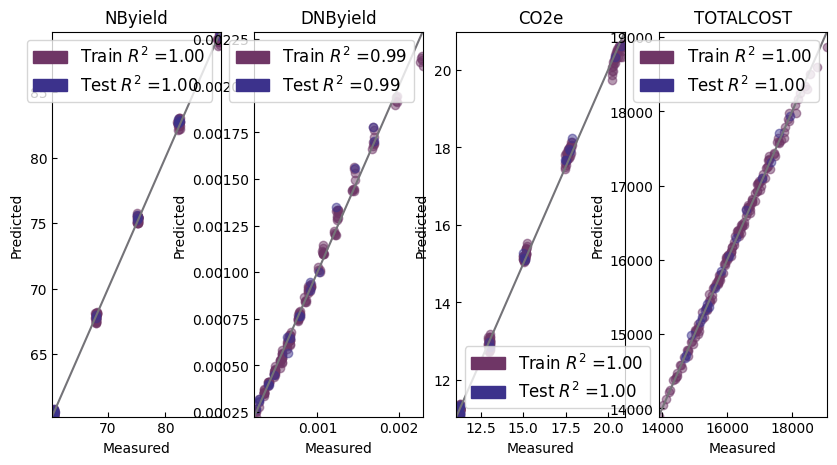

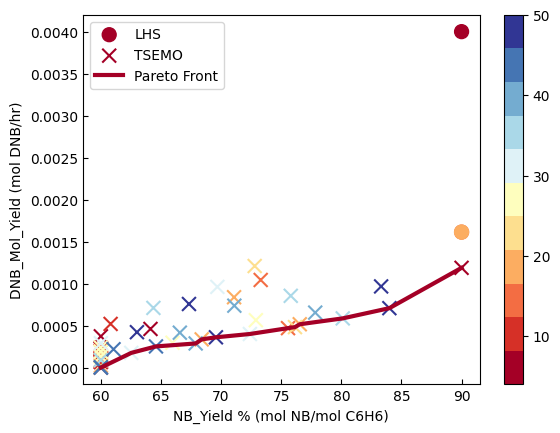

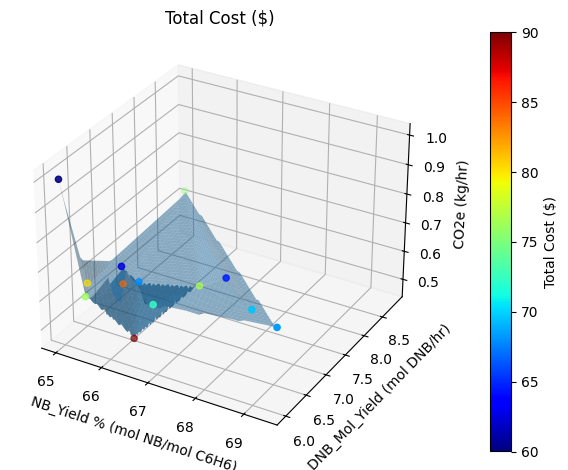

Creating plot for combination: ('NByield', 'DNByield')


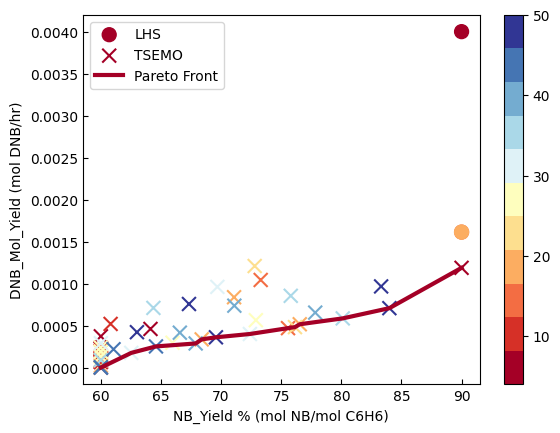

Creating plot for combination: ('NByield', 'CO2e')


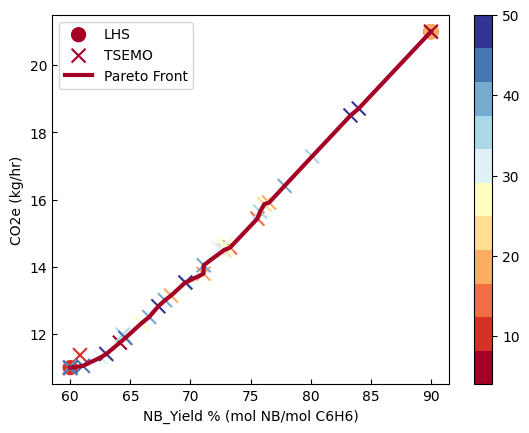

Creating plot for combination: ('NByield', 'TOTALCOST')


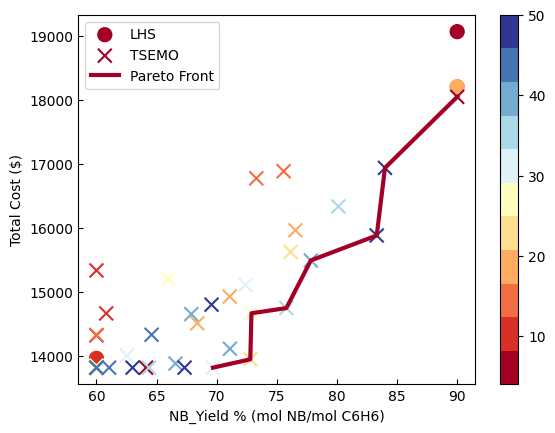

Creating plot for combination: ('DNByield', 'CO2e')


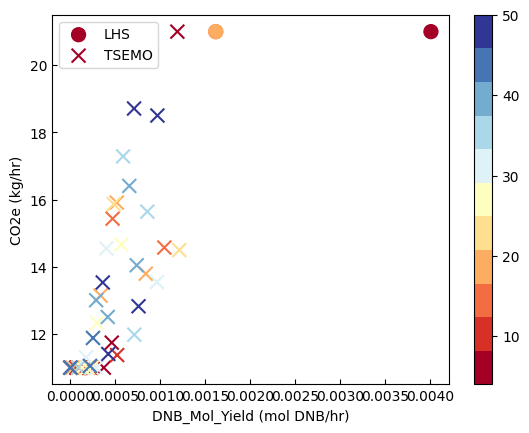

Creating plot for combination: ('DNByield', 'TOTALCOST')


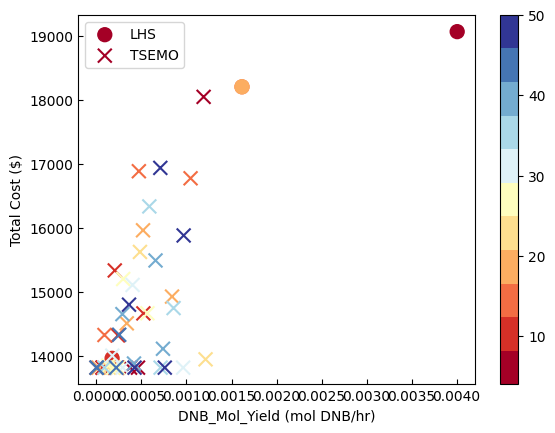

Creating plot for combination: ('CO2e', 'TOTALCOST')


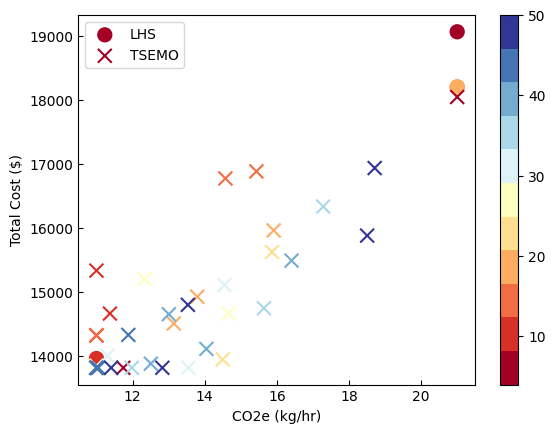

In [ ]:
file_path = "NitroBENZENE_DataMatrix_4O_2024_12_27_22_54_vars_units.csv"

ds = DataSet.read_csv(file_path)

ds_objvs = ds
ds = ds.iloc[:-2]
df = pd.read_csv(file_path, skiprows=[1])
df = df.iloc[:-2]
df_skip = pd.read_csv(file_path, skiprows=[1])

"""## Domain

We first need to create a :class:`~summit.domain.Domain`. A domain specifies the aspects of the reaction we will be optimizing. In optimization speak, these are the decision variables (those that are manipulated), constraints and objectives for a benchmark.
"""
# Parametric Domain creation
domain = Domain()

"""Above, we instantiate a new domain without any variables. Here, we are going to manipulate the catalyst, catalyst loading, base stoichiometry and temperature. Our objectives are to maximise yield and minimise turn over number (TON). We can use the increment operator `+=` to add variables to the domain. There are no constraints.

### Decision variables

Below, we use `ContinuousVariable` to specify the rest of the decision variables. Each has `bounds`, which represent the minimum and maximum values of each variable.
"""

# Define # of objectives and optimization direction
# Get the second last row of the DataFrame
last_row = ds_objvs.iloc[-2]

# Filter out the elements that are not "decision"
objective_directions = last_row[last_row != "decision"].tolist()

# Calculate the number of objectives
num_objectives = len(objective_directions)

# Print the results
print("num_objectives =", num_objectives)
print("objective_directions =", objective_directions)


# Extract column names excluding the first column
variables = df_skip.columns[1:].tolist()

# Set descriptions to be the same as variables
# descriptions = variables.copy()
descriptions = ds_objvs.iloc[-1].tolist()

# Print the results
print("variables =", variables)
print("descriptions =", descriptions)

# Decision variables

# Determine the decision variables and objective variables based on the number of objectives
decision_vars = variables[:-num_objectives]
decision_descriptions = descriptions[:-num_objectives]

objective_vars = variables[-num_objectives:]
objective_descriptions = descriptions[-num_objectives:]

# Build the domain based on the selection of is_objective
for var, desc in zip(decision_vars, decision_descriptions):
    # lower_bound = np.floor(df[var].min())

  # Convert the column to numeric, forcing errors to NaN
    df[var] = pd.to_numeric(df[var], errors='coerce')
    # Update the column to exclude the last row and drop NaN values
    df[var] = df[var].iloc[:-1].dropna()
    lower_bound = np.floor(df[var].min())
    upper_bound = np.ceil(df[var].max())
    domain += ContinuousVariable(name=var, description=desc, bounds=[lower_bound, upper_bound])



"""### Objectives

Finally, we specify the objectives. We use `ContinuousVariable` again, but set `is_objective` to `True` and specify whether to maximize (or minimize) each objective.
"""

# Objectives

for var, desc, direction in zip(objective_vars, objective_descriptions, objective_directions):
    # Convert the column to numeric, forcing errors to NaN
    df[var] = pd.to_numeric(df[var], errors='coerce')
    # Update the column to exclude the last row and drop NaN values
    df[var] = df[var].iloc[:-1].dropna()
    lower_bound = np.floor(df[var].min())
    upper_bound = np.ceil(df[var].max())
    maximize = True if direction == "maximize" else False
    domain += ContinuousVariable(
        name=var,
        description=desc,
        bounds=[lower_bound, upper_bound],
        is_objective=True,
        maximize=maximize
    )


"""When working inside a Jupyter Notebook, we can view the domain by putting it at the end of a cell and pressing enter.

#### Domain view
"""

domain

"""Note that we are using a :class:`~summit.dataset.Dataset`. In the CSV, it is essential that the columns match the domain and an extra row is added below each column name with the word DATA (see [here](https://github.com/sustainable-processes/summit/blob/master/summit/benchmarks/data/reizman_suzuki_case_1.csv) for an example).

## Train the Emulator

Now we only need two lines to train the experimental emulator!  We first instantiate `ExperimentalEmulator` passing in the dataset, domain and a name for the model.  Next we train it with two-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) and a test set size of 25%.

This step will take some time. Change verbose to 1 if you want streaming updates of the training.
"""

emul = ExperimentalEmulator(model_name='my_reizman', domain=domain, dataset=ds)
emul.train(max_epochs=1000, cv_fold=2, test_size=0.1, verbose=0)

"""The training returns a `scores` dictionary from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate), which contains the results from each cross-validation fold. It might be difficult to understand these scores, so we show some more intuitive evaluation methods next.

## Evaluate Emulator

A [parity plot](https://en.wikipedia.org/wiki/Parity_plot) shows experimental data against model predictions. We can do this for both the train and test sets. The $r^2$ score is shown, which varies between 0 and 1 with 1 being perfect fit.
"""

fig, ax = emul.parity_plot(include_test=True)

"""## Run TSEMO"""

exp=emul


strategy = TSEMO(exp.domain, transform=None)

# Use the runner to run closed loop optimisation
r = Runner(
    strategy=strategy, experiment=exp,max_iterations=50
)
r.run()

## Pareto plot

print(objective_vars)
print(objective_descriptions)
# Plot the results
fig, ax = exp.pareto_plot(colorbar=True)
# _ = ax.set_xlabel('NB_Yield % (mol/mol)')
# _ = ax.set_ylabel('DNB_Yield (mol/hr)')
_ = ax.set_xlabel(objective_descriptions[0])
_ = ax.set_ylabel(objective_descriptions[1])
exp.pareto_data.round(2)
par_eto = exp.pareto_data.round(2)
print(type(par_eto))
print(par_eto)
# 4 OBJECTIVES - Heat Map with 3 objectives in x, y and z and a 4th objective with colors

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

data = par_eto
# Create the ndarray
Obj4_pareto_ndarray = np.array(data)

# Print the ndarray to verify
print(Obj4_pareto_ndarray)
T_Rs_Rt_dummy=Obj4_pareto_ndarray
print(num_objectives)
from scipy.interpolate import griddata

# Check if num_objectives is 4
if num_objectives == 4:
    # Extract columns for plotting
    x = T_Rs_Rt_dummy[:, 0]
    y = T_Rs_Rt_dummy[:, 1]
    z = T_Rs_Rt_dummy[:, 2]
    w = T_Rs_Rt_dummy[:, 3]

    # Create 3D scatter plot with heat map
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, c=w, cmap='jet')

    # Draw the surface produced by the values of the three variables
    # Create grid data for surface plot
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear')

    # Plot the surface
    ax.plot_surface(xi, yi, zi, alpha=0.5)

    # Add color bar which maps values to colors
    colorbar = plt.colorbar(sc, pad=0.1)  # Adjust pad to move color bar away from the plot
    colorbar.set_label(objective_descriptions[3])  # Use the 4th element of the array

    # Set labels
    # Set labels using the content of the array 'objective_descriptions'
    # objective_descriptions = ['NB_Yield % (mol NB/mol C6H6)', 'DNB_Mol_Yield (mol DNB/hr)', 'CO2e (kg/hr)']
    ax.set_xlabel(objective_descriptions[0])
    ax.set_ylabel(objective_descriptions[1])
    ax.set_zlabel(objective_descriptions[2])
    ax.set_title(objective_descriptions[3])

    # Adjust layout to ensure labels are fully visible
    plt.tight_layout()

    plt.show()
# 2D Plot - all objective pairs
import itertools
import matplotlib.pyplot as plt

# Generate all possible combinations of columns
combinations = list(itertools.combinations(objective_vars, 2))
des_combinat = list(itertools.combinations(objective_descriptions, 2))

# Function to create plots for each combination and show the combinations
def create_plots(combinations, des_combinat):
    for combo, des_combo in zip(combinations, des_combinat):
        print(f"Creating plot for combination: {combo}")
        fig, ax = exp.pareto_plot(objectives=list(combo), colorbar=True)
        _ = ax.set_xlabel(des_combo[0])
        _ = ax.set_ylabel(des_combo[1])
        plt.show()

# Create plots for all combinations and show the combinations
create_plots(combinations, des_combinat)

# # Create plots for all combinations and show the combinations
# create_plots(combinations)